In [27]:
import os
os.environ['PROJ_LIB'] ='C:/Users/ebdl/Anaconda3/Library/share/proj'

In [29]:
import os 
import time
import shutil
import requests
import gc
from tqdm.auto import tqdm


import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

import tifffile
import rasterio
from pyidw import idw # 보간법 실행
import geopandas as gpd # geo 데이터프레임 만들기 위함
from rasterio.plot import show # 래스터 시각화
from shapely.geometry import Point
from rasterio.features import geometry_mask
from rasterio.transform import from_origin
from osgeo import gdal, ogr
from glob import glob

In [2]:
%pwd

'C:\\Users\\ebdl\\산불예측\\산불예측'

In [31]:
data1=pd.read_csv('structed_fire_data.csv',encoding='cp949',index_col='Unnamed: 0')
data2=pd.read_csv('structed_nofire_data.csv',encoding='cp949',index_col='Unnamed: 0')

In [32]:
data1['target']=1

In [33]:
data2['발생시간']=999
data2['날씨']='없음'
data2['특보내용']='없음'
data2['target']=0

In [34]:
data1

,field1,i,j,lon,lat,습도,강수,기온,풍속,발생시간,날씨,특보내용,target
0,20160721,145,313,128.871809,37.786543,40.128791,0.000000,-2.467752,3.945949,999,없음,없음,1
1,20160601,143,310,128.854779,37.797953,54.952699,0.000000,1.049347,1.936912,999,없음,없음,1
2,20140221,216,152,127.957879,37.381517,23.066370,0.000000,13.431703,1.434781,999,없음,없음,1
3,20180210,244,139,127.884083,37.221789,46.988972,0.012152,-6.417820,1.834428,999,없음,없음,1
4,20110219,147,183,128.133853,37.775134,56.415674,0.000000,1.448924,2.580111,999,없음,없음,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1048,20201102,94,206,128.264414,38.077478,72.982431,0.018083,7.762557,3.856538,999,없음,없음,1
1049,20140228,76,80,127.549164,38.180160,31.472493,0.000000,12.683992,2.840163,999,없음,없음,1
1050,20120207,167,160,128.003291,37.661042,72.069482,0.000000,7.687654,0.620234,999,없음,없음,1
1051,20140223,226,152,127.957879,37.324471,23.018648,0.000000,20.798500,3.076569,999,없음,없음,1


In [35]:
data2

,field1,i,j,lon,lat,습도,강수,기온,풍속,발생시간,날씨,특보내용,target
0,20160721,129,160,128.003291,37.877817,65.721596,0.0,24.389631,1.453097,999,없음,없음,0
1,20160601,165,102,127.674049,37.672451,51.780365,0.0,18.521161,1.774259,999,없음,없음,0
2,20140221,219,323,128.928575,37.364403,64.609462,0.0,1.351082,1.637306,999,없음,없음,0
3,20180210,160,151,127.952202,37.700974,73.634628,0.0,-3.365851,0.432005,999,없음,없음,0
4,20110219,140,137,127.872730,37.815066,80.610205,0.0,-5.039165,0.413060,999,없음,없음,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1087,20211115,128,146,127.923819,37.883521,94.053007,0.0,2.146356,0.277835,999,없음,없음,0
1088,20190217,112,100,127.662696,37.974795,85.655821,0.0,-8.746485,0.525876,999,없음,없음,0
1089,20140217,84,124,127.798934,38.134524,63.784203,0.0,1.323292,2.931593,999,없음,없음,0
1090,20140225,89,109,127.713785,38.106001,90.089028,0.0,-1.105872,0.578714,999,없음,없음,0


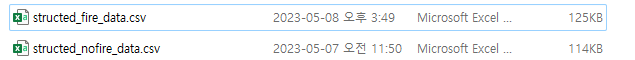

In [36]:
result = pd.concat([data1, data2])

In [37]:
result

,field1,i,j,lon,lat,습도,강수,기온,풍속,발생시간,날씨,특보내용,target
0,20160721,145,313,128.871809,37.786543,40.128791,0.000000,-2.467752,3.945949,999,없음,없음,1
1,20160601,143,310,128.854779,37.797953,54.952699,0.000000,1.049347,1.936912,999,없음,없음,1
2,20140221,216,152,127.957879,37.381517,23.066370,0.000000,13.431703,1.434781,999,없음,없음,1
3,20180210,244,139,127.884083,37.221789,46.988972,0.012152,-6.417820,1.834428,999,없음,없음,1
4,20110219,147,183,128.133853,37.775134,56.415674,0.000000,1.448924,2.580111,999,없음,없음,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1087,20211115,128,146,127.923819,37.883521,94.053007,0.000000,2.146356,0.277835,999,없음,없음,0
1088,20190217,112,100,127.662696,37.974795,85.655821,0.000000,-8.746485,0.525876,999,없음,없음,0
1089,20140217,84,124,127.798934,38.134524,63.784203,0.000000,1.323292,2.931593,999,없음,없음,0
1090,20140225,89,109,127.713785,38.106001,90.089028,0.000000,-1.105872,0.578714,999,없음,없음,0


In [38]:
data=result

In [10]:
data.drop(['Unnamed: 0','index'],axis=1,inplace=True)

In [24]:
data

,field1,i,j,lon,lat,습도,강수,기온,풍속,발생시간,날씨,특보내용,target
0,20160721,145,313,128.871809,37.786543,40.128791,0.000000,-2.467752,3.945949,999,없음,없음,1
1,20160601,143,310,128.854779,37.797953,54.952699,0.000000,1.049347,1.936912,999,없음,없음,1
2,20140221,216,152,127.957879,37.381517,23.066370,0.000000,13.431703,1.434781,999,없음,없음,1
3,20180210,244,139,127.884083,37.221789,46.988972,0.012152,-6.417820,1.834428,999,없음,없음,1
4,20110219,147,183,128.133853,37.775134,56.415674,0.000000,1.448924,2.580111,999,없음,없음,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1087,20211115,128,146,127.923819,37.883521,94.053007,0.000000,2.146356,0.277835,999,없음,없음,0
1088,20190217,112,100,127.662696,37.974795,85.655821,0.000000,-8.746485,0.525876,999,없음,없음,0
1089,20140217,84,124,127.798934,38.134524,63.784203,0.000000,1.323292,2.931593,999,없음,없음,0
1090,20140225,89,109,127.713785,38.106001,90.089028,0.000000,-1.105872,0.578714,999,없음,없음,0


In [47]:
data=data.reset_index(drop=True)

In [48]:
data

,field1,i,j,lon,lat,습도,강수,기온,풍속,발생시간,날씨,특보내용,target
0,20160721,145,313,128.871809,37.786543,40.128791,0.000000,-2.467752,3.945949,999,없음,없음,1
1,20160601,143,310,128.854779,37.797953,54.952699,0.000000,1.049347,1.936912,999,없음,없음,1
2,20140221,216,152,127.957879,37.381517,23.066370,0.000000,13.431703,1.434781,999,없음,없음,1
3,20180210,244,139,127.884083,37.221789,46.988972,0.012152,-6.417820,1.834428,999,없음,없음,1
4,20110219,147,183,128.133853,37.775134,56.415674,0.000000,1.448924,2.580111,999,없음,없음,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2140,20211115,128,146,127.923819,37.883521,94.053007,0.000000,2.146356,0.277835,999,없음,없음,0
2141,20190217,112,100,127.662696,37.974795,85.655821,0.000000,-8.746485,0.525876,999,없음,없음,0
2142,20140217,84,124,127.798934,38.134524,63.784203,0.000000,1.323292,2.931593,999,없음,없음,0
2143,20140225,89,109,127.713785,38.106001,90.089028,0.000000,-1.105872,0.578714,999,없음,없음,0


In [49]:
def crop_image_using_coordinates(InputImage, OutputImage, RefImage, latitude, longitude, InputCrs, OutputCrs, CropSize):
    """extract tiff height and width"""
    Image = gdal.Open(RefImage, gdal.GA_ReadOnly)
    width = Image.RasterXSize
    height = Image.RasterYSize
    Image = None

    """extract vertex coordinates"""
    rds = rasterio.open(RefImage)
    rds.bounds
    left = rds.bounds[0]
    right = rds.bounds[2]
    top = rds.bounds[3]
    bottom = rds.bounds[1]

    """Convert coordinates system"""
    resolution_x = (right - left) / width
    resolution_y = (top - bottom) / height

    InputCrs = _STATIC_formatting_crs(InputCrs)
    OutputCrs = _STATIC_formatting_crs(OutputCrs)
    transformer = Transformer.from_crs(InputCrs, OutputCrs)
    longitude, latitude = transformer.transform(longitude, latitude)
   
    left_box = latitude - (resolution_x * CropSize)
    top_box = longitude + (resolution_y * CropSize)
    right_box = latitude + (resolution_x * CropSize)
    bottom_box = longitude - (resolution_y * CropSize)
    window = (left_box, top_box, right_box, bottom_box)

    gdal.Translate(OutputImage, InputImage, projWin = window)
   
def _STATIC_formatting_crs(crs):
    if '4326' in str(crs):
        crs = 'EPSG:4326'
    elif '5179' in str(crs):
        crs = 'EPSG:5179'
    return crs

In [50]:
from pyproj import Proj, Transformer

In [51]:
from tqdm import tqdm

In [52]:
InputImage = 'forestmap.tif'
RefImage = 'gw_boundary.tif'
for i in tqdm(range(len(data))):
    OutputImage = f'forestmap/forestmap{i}.tif'
    lon=data['lon'][i]
    lat=data['lat'][i]
    crop_image_using_coordinates(InputImage, OutputImage, RefImage, lon, lat, '4326', '4326', 25)

100%|██████████████████████████████████████████████████████████████████████████████| 2145/2145 [00:41<00:00, 51.34it/s]


In [53]:
folder_path = 'forestmap' # 대상 폴더 경로
file_names = os.listdir(folder_path) # 폴더 내 파일 이름 리스트 반환
print(file_names)

['forestmap0.tif', 'forestmap1.tif', 'forestmap10.tif', 'forestmap100.tif', 'forestmap1000.tif', 'forestmap1001.tif', 'forestmap1002.tif', 'forestmap1003.tif', 'forestmap1004.tif', 'forestmap1005.tif', 'forestmap1006.tif', 'forestmap1007.tif', 'forestmap1008.tif', 'forestmap1009.tif', 'forestmap101.tif', 'forestmap1010.tif', 'forestmap1011.tif', 'forestmap1012.tif', 'forestmap1013.tif', 'forestmap1014.tif', 'forestmap1015.tif', 'forestmap1016.tif', 'forestmap1017.tif', 'forestmap1018.tif', 'forestmap1019.tif', 'forestmap102.tif', 'forestmap1020.tif', 'forestmap1021.tif', 'forestmap1022.tif', 'forestmap1023.tif', 'forestmap1024.tif', 'forestmap1025.tif', 'forestmap1026.tif', 'forestmap1027.tif', 'forestmap1028.tif', 'forestmap1029.tif', 'forestmap103.tif', 'forestmap1030.tif', 'forestmap1031.tif', 'forestmap1032.tif', 'forestmap1033.tif', 'forestmap1034.tif', 'forestmap1035.tif', 'forestmap1036.tif', 'forestmap1037.tif', 'forestmap1038.tif', 'forestmap1039.tif', 'forestmap104.tif', 'for

In [54]:
file_names=[i[:-4] for i in file_names]
file_names

['forestmap0',
 'forestmap1',
 'forestmap10',
 'forestmap100',
 'forestmap1000',
 'forestmap1001',
 'forestmap1002',
 'forestmap1003',
 'forestmap1004',
 'forestmap1005',
 'forestmap1006',
 'forestmap1007',
 'forestmap1008',
 'forestmap1009',
 'forestmap101',
 'forestmap1010',
 'forestmap1011',
 'forestmap1012',
 'forestmap1013',
 'forestmap1014',
 'forestmap1015',
 'forestmap1016',
 'forestmap1017',
 'forestmap1018',
 'forestmap1019',
 'forestmap102',
 'forestmap1020',
 'forestmap1021',
 'forestmap1022',
 'forestmap1023',
 'forestmap1024',
 'forestmap1025',
 'forestmap1026',
 'forestmap1027',
 'forestmap1028',
 'forestmap1029',
 'forestmap103',
 'forestmap1030',
 'forestmap1031',
 'forestmap1032',
 'forestmap1033',
 'forestmap1034',
 'forestmap1035',
 'forestmap1036',
 'forestmap1037',
 'forestmap1038',
 'forestmap1039',
 'forestmap104',
 'forestmap1040',
 'forestmap1041',
 'forestmap1042',
 'forestmap1043',
 'forestmap1044',
 'forestmap1045',
 'forestmap1046',
 'forestmap1047',
 'for